In [1]:
# i need them all 
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import PIL.Image as Image
import pathlib
import cv2
import os
import gc

--- DOWNLOADING DATASET ---

In [22]:
def get_set_of_directory(path):
    return {os.path.join(path, e) for e in os.listdir(path) if os.path.isdir(os.path.join(path, e))}

In [23]:

cache_dir = '..'
cache_subdir = 'datasets'

cache_path = os.path.join(cache_dir, cache_subdir)

In [24]:
# get dogs images
dog_dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

# get diffrence of directory to get extracted folder path
dirs = get_set_of_directory(cache_path)

tf.keras.utils.get_file('dog_photos', origin = dog_dataset_url,  cache_dir = cache_dir, cache_subdir = cache_subdir, untar = True)

# get actual folder
dog_data_dir = (get_set_of_directory(cache_path) - dirs).pop()
dog_data_dir

'..\\datasets\\Images'

In [25]:
# get no dog images
non_dog_dataset_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar"

# get diffrence of directory to get extracted folder path
dirs = get_set_of_directory(cache_path)

tf.keras.utils.get_file('objects_photos', origin = non_dog_dataset_url,  cache_dir=  cache_dir, cache_subdir = cache_subdir, untar = True)

non_dog_data_dir = (get_set_of_directory(cache_path) - dirs).pop()
non_dog_data_dir

'..\\datasets\\256_ObjectCategories'

In [26]:
# bit of cleaning doesnt hurt
del dirs

In [27]:
# get the dog images 
dog_data_dir = pathlib.Path(dog_data_dir)
dog_images_paths = list(dog_data_dir.glob(f'*/*.jpg'))

dog_images_paths = list(map(str, dog_images_paths))

len(dog_images_paths)

20580

In [28]:
# get non-dogs images
non_dog_data_dir = pathlib.Path(non_dog_data_dir)

non_dog_images_paths = list(non_dog_data_dir.glob(f'*/*.jpg'))

# get rid of dog category
non_dog_images_paths = [str(path) for path in non_dog_images_paths if not 'dog' in str(path)]

len(non_dog_images_paths)

30420

In [29]:
# cleaning
del non_dog_dataset_url, dog_dataset_url, non_dog_data_dir, \
    dog_data_dir, cache_path, cache_subdir, cache_dir

In [30]:
# ----- save list of image paths ------
np.savez_compressed('./images_path', non_dogs = np.array(non_dog_images_paths), dogs = np.array(dog_images_paths))

In [4]:
# ----- load list of image path -------
loaded = np.load('./images_path.npz')

non_dog_images_paths= loaded['non_dogs']
dog_images_paths = loaded['dogs']

# remove :/
del loaded

print(non_dog_images_paths.shape, dog_images_paths.shape)

(30420,) (20580,)


--- PREPARE DATASET ---

In [ ]:
# limit length of dataset (20k is a bit too big)
HARD_LIMIT = 5000

samples_count = min(len(dog_images_paths), len(non_dog_images_paths), HARD_LIMIT)

dog_images_paths = dog_images_paths[:samples_count]
non_dog_images_paths = non_dog_images_paths[:samples_count]

print(len(dog_images_paths), len(non_dog_images_paths))

In [6]:
# prepare the data for taining
x, y = [], []

x = np.concatenate((dog_images_paths, non_dog_images_paths))

y = [1] * len(dog_images_paths) + \
    [0] * len(non_dog_images_paths)


print(x[:5],'\n', y[:5])
print(len(x), len(y))

['..\\datasets\\Images\\n02085620-Chihuahua\\n02085620_10074.jpg'
 '..\\datasets\\Images\\n02085620-Chihuahua\\n02085620_10131.jpg'
 '..\\datasets\\Images\\n02085620-Chihuahua\\n02085620_10621.jpg'
 '..\\datasets\\Images\\n02085620-Chihuahua\\n02085620_1073.jpg'
 '..\\datasets\\Images\\n02085620-Chihuahua\\n02085620_10976.jpg'] 
 [1, 1, 1, 1, 1]
10000 10000


In [7]:
# convert into numpy array
x = np.array(x)
y = np.array(y)

In [8]:
# split the data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

print(x_train.shape, x_test.shape)

(7500,) (2500,)


In [9]:
# let GC to handle this mess
del x, y

gc.collect()

672

In [10]:
NN_IMAGE_SIZE = (224, 224)

# creata data generators
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # load, resize, scale images
        images = np.array([cv2.resize(cv2.imread(pth), NN_IMAGE_SIZE) for pth in batch_x])/255
        return images, batch_y
    
train_gen = DataGenerator(x_train, y_train, 32)
test_gen = DataGenerator(x_test, y_test, 32)

--- PREPARE NN MODEL ---

In [2]:
NN_IMAGE_SIZE = (224, 224)
# Lets "borrow" (stole) pretrained model from google 
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape = NN_IMAGE_SIZE + (3,), trainable = False)

In [3]:
# create model with only last layer
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(1) # dog or no dog 
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [4]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy',],
)

In [ ]:
# have fun training it 
model.fit(train_gen,
          epochs = 10)

In [ ]:
# got 0.991 acc 
model.evaluate(test_gen) 

In [18]:
# ---- save model ----
model.save_weights('./model/model')

In [5]:
# ---- load weights ----
model.load_weights('./model/model')

In [19]:
# free the memory
del x_train, x_test, y_test, y_train
gc.collect()

57372

--- OBJECT DETECTION ---

In [ ]:
def predict(img):
    output = model.predict(np.array([img,]), verbose = 0)
    return output[0][0]

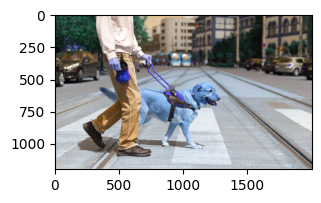

In [9]:
# ----- sliding window technique-----

# load image
image_path = 'search.jpg'
image = cv2.imread(image_path)

img_height, img_width, _=  image.shape

plt.figure(figsize = (15,2))
plt.imshow(image)

In [ ]:
# create dog-heatmap
heatmap = np.zeros(shape = image.shape[:-1])

search_box_width = 300
search_box_height = 300

# iterate over each pixel🙃🔫
# had to do multiprocessing bcoz doing it one by one would take ages
import concurrent.futures
from tqdm import tqdm

def process_image_slice(x, y):
    image_slice = cv2.resize(image[y:y+search_box_height, x : x + search_box_width], NN_IMAGE_SIZE)/255
    prediction = predict(image_slice)

    return x, y, prediction

def update_heatmap(result):
    x, y, prediction = result
    heatmap[y:y+search_box_height, x : x + search_box_width] += prediction

searching_step = 25
coords = [(x, y) for x in range(0, img_width - search_box_width, searching_step) for y in range(0, img_height - search_box_height, searching_step)]

num_processes = 5
pbar = tqdm(total = len(coords))


with concurrent.futures.ThreadPoolExecutor(max_workers = num_processes) as executor:
    # Submit the tasks to the executor
    futures = [executor.submit(process_image_slice, x, y) for x, y in coords]

    # Process the results as they become available
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        update_heatmap(result)
        pbar.update(1)

# close the progress bar
pbar.close() 

--- PROCESS THE RESULTS ---

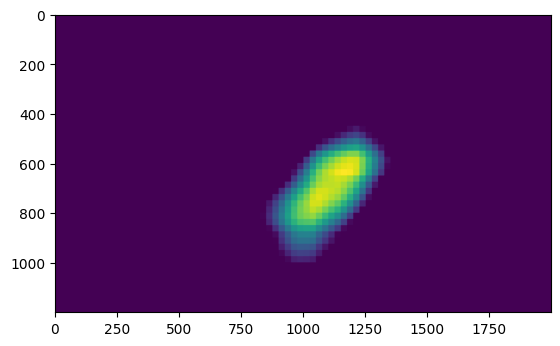

In [40]:
heatmap_copy = heatmap.copy()
image_copy = image.copy()

heatmap_copy[heatmap_copy<0] = 0
plt.imshow(heatmap_copy)


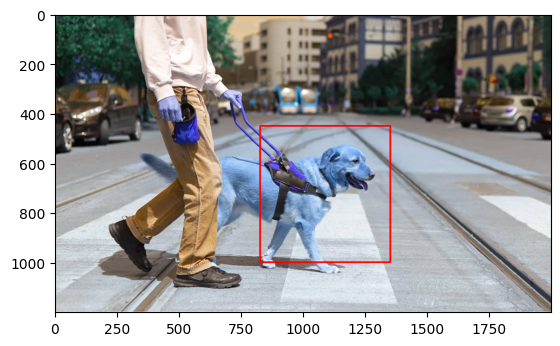

In [41]:
# find bounding boxes
def find_bounding_box(array):
    # Find the indices where values are above 0
    indices = np.argwhere(array > 0)
    
    if len(indices) == 0:
        return None
    
    # Get the minimum and maximum indices along each axis
    min_indices = np.min(indices, axis = 0)
    max_indices = np.max(indices, axis = 0)
    
    # Calculate the bounding box coordinates
    y_min, x_min = min_indices
    y_max, x_max = max_indices
    
    return ((x_min, y_min), (x_max, y_max))



rect = find_bounding_box(heatmap_copy)
cv2.rectangle(image_copy, *rect, (255,0,0), 6)

plt.imshow(image_copy)
